In [1]:
### importing qcomp ###
include("../src/qcomp.jl")
using .qcomp

using Yao
using YaoPlots
using LinearAlgebra
using PyPlot
using Random

In [24]:
# circ = build_QCNN(4)
# YaoPlots.plot(circ)

In [30]:
typeof(chain(3))<:ChainBlock

true

In [3]:
#Example use (random states vs uniform state)

seed = 2
Random.seed!(seed)

n = 4

states1 = [rand_state(n) for i=1:10]
states2 = [uniform_state(n) for i=1:10]
states = vcat([states1, states2]...)
labels = vcat([repeat([1],10), repeat([-1],10)]...)

test_states1 = [rand_state(n) for i=1:10]
test_states2 = [uniform_state(n) for i=1:10]
test_states = vcat([test_states1, test_states2]...)
test_labels = vcat([repeat([1],10), repeat([-1],10)]...);

In [7]:
iters = 300
lr = 0.05
sig = true

circ = build_QCNN(n)
p = GenericParams(n=n, circ=circ)
# p = InvariantParams(n=n, circ=circ)
initialize_params(p);

In [8]:
params, loss_track, tr_track, te_track, tr_preds, te_preds = train_test_model(states, labels, test_states, test_labels, p, iters, sig, lr; output=false)

Initial: loss = 0.8289944074721136,tr_acc = 0.7, te_acc = 0.7
Final: loss = 0.0007413485401132574,tr_acc = 1.0, te_acc = 0.75


([3.8947130149200406, 5.665310764893893, 2.772649080342284, 2.6271025162386, -0.8549378963171836, 2.9377225663143505, 5.116354474416996, 1.1758413914793207, 3.3284826531841754, 6.018869363326633, 4.505961681976383, 6.631618172662311], [0.8289944074721136, 0.7439211709803383, 0.6537971776696938, 0.5589925984725566, 0.45480720047747614, 0.3545063087095201, 0.27890804919514717, 0.23211164488680125, 0.20649247929623804, 0.1928591498248738  …  0.0007436001095599649, 0.0007433394149433816, 0.0007430814350186119, 0.0007428261325034525, 0.0007425734708056442, 0.0007423234140064724, 0.0007420759268448211, 0.0007418309747015629, 0.0007415885235844432, 0.0007413485401132574], [0.7, 0.75, 0.8, 0.8, 0.85, 0.9, 0.9, 0.95, 0.95, 0.95  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.7, 0.7, 0.7, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75  …  0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75], Any[0.965382671256314, 0.9929616338406706, 0.9500018988739451, 0.9728804267340594, 0.963410829

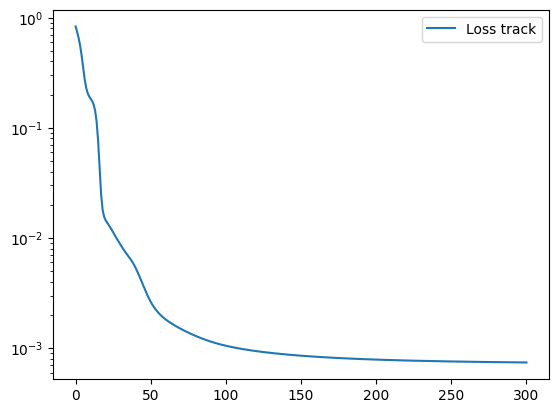

In [9]:
PyPlot.semilogy(0:iters, loss_track, label="Loss track")
PyPlot.legend()
PyPlot.display_figs()

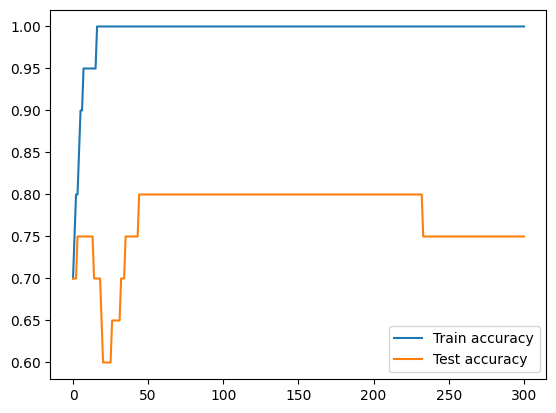

In [10]:
PyPlot.plot(0:iters, tr_track, label="Train accuracy")
PyPlot.plot(0:iters, te_track, label="Test accuracy")
PyPlot.legend()
PyPlot.display_figs()

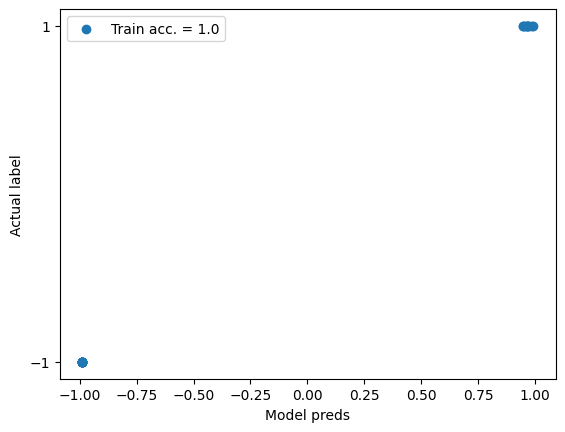

In [11]:
PyPlot.scatter(tr_preds, labels, label="Train acc. = $(round(tr_track[end],digits=2))")
#PyPlot.scatter(te_preds, test_labels, label="Test acc. = $(round(te_track[end],digits=2))")
PyPlot.xlabel("Model preds")
PyPlot.ylabel("Actual label")
PyPlot.yticks(-1:2:1)
PyPlot.legend()
PyPlot.display_figs()